# Measurement Memo II 
## Tereza Petrovicova 
### November 25



*In this measurement memo, you will use your hand coded training set to classify your documents into categories.  Please submit your R code along with your memo (you do not have to submit your data).*

Supervised learning.  Augment your hand coded dataset from last time to categorize many more examples (200 might be a good starting point).  

A.  Use the bag of words representation to represent your training and unlabeled data.  Train several different classifiers to predict your categories.  Which classifier works the best?  How do you know?

B.  Train a feed-forward neural network to predict your outcome.   Does this model improve on your previous classifier?  Why or why not?

C.  Use ChatGPT 4o-mini or another LLM to complete a zero-shot classification of your training data, providing the LLM with your codebook.  Compare the LLM's performance to your best performing model from A and B.  Which performs better?

D.  Use your best performing model to categorize your unlabeled data.  (If your best performing model is ChatGPT, you might use your second best of the cost is prohibitive.). What proportion of each category is in your corpus?  What does this tell you about your research question?

### Loading Data 
I randomly sampleted 2 snippetes from each of the 135 companies in my sample. I then excluded the 50 chunks I already analyzed in Measurement Memo I. 

In [105]:
import pandas as pd
import os

# Set the working directory
os.chdir("/Users/teri/Documents/GitHub/Energy10k")

# Read sample of 50 and 270
sample50 = pd.read_csv("sample50.csv")
sample270 = pd.read_csv("sample270.csv")

In [106]:
# excluding 50 from the 270 

# Perform a left join on 'ticker' and 'chunk_number' and filter out matches
merged = sample270.merge(sample50[['ticker', 'chunk_number']], on=['ticker', 'chunk_number'], how='left', indicator=True)

# Keep only the rows in sample270 that do not have a match in sample50
filtered_sample270 = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

# Save the result to a new CSV file
filtered_sample270.to_csv("sample220.csv", index=False)



## Part A: Bag of Words Representation and Classifiers 




In Part A I first load the hand-coded data as well as the other unlabeled data. Each observation is a 10 sentence chunk from a 10k document. The hand coded data contains 270 observation.  After loading in the hand-coded data, I performed a 25/75 split into training and testing data. I then proceded to run different classifiers including: Naive Bayes, Logistical Regression, Decision Tree and Random Forest. I then also calculated the 

For this memo, I decided to focus on the first measure: environemtnal regulation defined as: *This binary variable captures the presence of either environmental or energy regulation specifically within the text."* I have a more detailed definition which is *For an entry to be coded as "1," there must be an explicit reference to regulatory terms that are clearly related to environmental or energy concerns. General mentions of "governmental regulation" or similar non-specific terms are not included here. Examples of indicators include references to specific agencies or terms like "EPA regulations" or "energy compliance."*

In [107]:
## Loading Training and Unlabeled Data 

labeled = pd.read_csv("sample_270_coded.csv")
unlabeled = pd.read_csv("unlabeled_data.csv")

#dropping NAs
labeled = labeled.dropna(subset=['chunk_text', 'regulation_present'])

#checking number of trained chunks
#trained.shape[0]

In [108]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
import unicodedata  # For normalizing Unicode characters
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Function for text preprocessing: tokenization, removing punctuation, numbers, stopwords, symbols, and stemming
def preprocess_text(text, stop_words):
    # Normalize Unicode characters (remove accents)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')
    
    # Tokenize the text (split it into words)
    tokens = word_tokenize(text.lower())
    
    # Remove punctuation and symbols using regex (remove non-alphabetic characters, except spaces)
    tokens = [re.sub(r'[^\w\s]', '', word) for word in tokens]
    
    # Remove any remaining tokens that are now empty due to removal of symbols/punctuation
    tokens = [word for word in tokens if word]
    
    # Remove numbers (check if each token is alphabetic)
    tokens = [word for word in tokens if word.isalpha()]
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Apply stemming (reduce words to their root form)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Return a string by joining the tokens back into a single string (space-separated)
    return " ".join(tokens)


# Assuming 'labeled' DataFrame contains the labeled data with 'chunk_text' and 'regulation_present'
# Preprocess the labeled data (text only)
labeled_corpus = labeled['chunk_text'].tolist()

# Define stopwords (using NLTK stopwords)
stop_words = set(stopwords.words('english'))

# Apply preprocessing function to the labeled corpus
labeled_preprocessed = [preprocess_text(doc, stop_words) for doc in labeled_corpus]

# Define features and labels
vectorizer = CountVectorizer(min_df=5)  # min_df filters out words that appear in fewer than 5 documents
X = vectorizer.fit_transform(labeled_preprocessed)
y = labeled['regulation_present']

# Perform a 0.75 (training) / 0.25 (testing) split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Check the shape of the resulting splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(195, 1206) (65, 1206) (195,) (65,)


### Naive Bayes

In [109]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train the Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)  # Fit the model using training data (X_train, y_train)

# Predict on the testing data to evaluate out-of-sample performance
y_pred_nb = nb_model.predict(X_test)  # Predict using the test features (X_test)

# Evaluate performance on the testing data
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Testing Accuracy: {accuracy_nb:.4f}")

# Get the classification report for more detailed evaluation (precision, recall, F1 score)
class_report_nb = classification_report(y_test, y_pred_nb)
print("Testing Classification Report:")
print(class_report_nb)

# Confusion matrix for testing data to see how well the model performed
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print("\nConfusion Matrix (Testing Data):")
print(conf_matrix_nb)


Testing Accuracy: 0.8000
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84        41
         1.0       0.72      0.75      0.73        24

    accuracy                           0.80        65
   macro avg       0.78      0.79      0.79        65
weighted avg       0.80      0.80      0.80        65


Confusion Matrix (Testing Data):
[[34  7]
 [ 6 18]]


In [110]:
# ---- Extract Top 20 Words from Naive Bayes Model ----
import numpy as np

# Access the coefficients (log probability ratios) for each word in the vocabulary
coef = nb_model.feature_log_prob_[1] - nb_model.feature_log_prob_[0]  # Log-probability of words in the positive class vs. negative class
words = np.array(vectorizer.get_feature_names_out())  # Get the feature names (words)

# Create a DataFrame to view the words and their associated coefficients
coef_df = pd.DataFrame({'word': words, 'coef': coef})

# Sort the words by the magnitude of their coefficient to find the most associated words
coef_df_sorted = coef_df.sort_values(by='coef', ascending=False)

# Display the top 20 words most associated with regulation_present
top_words = coef_df_sorted.head(20)

# Display the top words
print("\nTop 20 words most associated with regulation_present (Naive Bayes with CountVectorizer):")
print(top_words)


Top 20 words most associated with regulation_present (Naive Bayes with CountVectorizer):
           word      coef
383         epa  3.834851
364       emiss  3.753358
475     fractur  3.695089
507   greenhous  3.695089
532     hydraul  3.617127
42          air  3.532570
172  climaterel  3.407407
788        pari  3.338414
489        gase  3.184263
697      methan  3.141703
495         ghg  3.097252
316      dioxid  3.097252
623        land  2.778798
117       biden  2.778798
680   mandatori  2.778798
843      presid  2.778798
171      climat  2.778798
472      fossil  2.736238
579     injunct  2.645267
100         ban  2.645267


### Logit 

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import numpy as np

# Step 1: Convert the target variable to integer type (binary classification)
y_train = y_train.astype(int)  # Ensure training labels are in integer format (binary)
y_test = y_test.astype(int)    # Ensure testing labels are in integer format (binary)

# Step 2: Train a Logistic Regression model using the training data (X_train, y_train)
log_reg_model = LogisticRegression(max_iter=10000)  # Ensure sufficient iterations
log_reg_model.fit(X_train, y_train)  # Fit the model using X_train and y_train

# Step 3: Predict on the testing data to check out-of-sample performance
y_pred_logit = log_reg_model.predict(X_test)

# Step 4: Evaluate performance on the testing data
accuracy_logit = accuracy_score(y_test, y_pred_logit)
print(f"Testing Accuracy: {accuracy_logit:.4f}")

# Get the classification report for more detailed evaluation (precision, recall, F1 score)
class_report_logit = classification_report(y_test, y_pred_logit)
print("Testing Classification Report:")
print(class_report_logit)

# Confusion matrix for testing data to see how well the model performed
conf_matrix_logit = confusion_matrix(y_test, y_pred_logit)
print("\nConfusion Matrix (Testing Data):")
print(conf_matrix_logit)




Testing Accuracy: 0.8154
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        41
           1       0.77      0.71      0.74        24

    accuracy                           0.82        65
   macro avg       0.80      0.79      0.80        65
weighted avg       0.81      0.82      0.81        65


Confusion Matrix (Testing Data):
[[36  5]
 [ 7 17]]


In [112]:

# Access the coefficients from the Logistic Regression model
coef = log_reg_model.coef_.flatten()  # Flatten the coefficients for easier access
words = np.array(vectorizer.get_feature_names_out())  # Get the feature names (words) from CountVectorizer

# Create a DataFrame to view the words and their associated coefficients
coef_df = pd.DataFrame({'word': words, 'coef': coef})

# Sort the words by the magnitude of their coefficient to find the most associated words
coef_df_sorted = coef_df.sort_values(by='coef', ascending=False)

# Display the top 20 words most associated with the 'regulation_present' category
top_words = coef_df_sorted.head(20)
print("\nTop 20 Words Most Associated with 'regulation_present':")
print(top_words)


Top 20 Words Most Associated with 'regulation_present':
             word      coef
364         emiss  0.398711
171        climat  0.332746
909         reduc  0.328918
919         regul  0.315916
1123    transmiss  0.307890
577         initi  0.292809
921    regulatori  0.259237
360        electr  0.253569
934         renew  0.248483
544         impos  0.241704
382   environment  0.239729
1048       storag  0.237808
957        retail  0.236770
815        permit  0.229524
602        invest  0.226099
20          addit  0.222323
372        energi  0.222001
918       registr  0.217839
724         natur  0.213350
472        fossil  0.208299


### Decision Tree 

In [113]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Assuming 'y_train' and 'X_train' are the training features and labels,
# and 'y_test' and 'X_test' are the testing features and labels.

# Convert the target variable to integer type (binary classification) for training and testing sets
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Train a Decision Tree Classifier using the training data (X_train, y_train)
dt_model = DecisionTreeClassifier(random_state=42)  # Set random state for reproducibility
dt_model.fit(X_train, y_train)  # Fit the model using training data

# Predict on the testing data to check out-of-sample performance
y_pred_dt = dt_model.predict(X_test)

# Evaluate performance on the testing data
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Testing Accuracy: {accuracy_dt:.4f}")

# Get the classification report for more detailed evaluation (precision, recall, F1 score)
class_report_dt = classification_report(y_test, y_pred_dt)
print("Testing Classification Report:")
print(class_report_dt)

# Confusion matrix for testing data to see how well the model performed
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("\nConfusion Matrix (Testing Data):")
print(conf_matrix_dt)


Testing Accuracy: 0.7385
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        41
           1       0.71      0.50      0.59        24

    accuracy                           0.74        65
   macro avg       0.73      0.69      0.70        65
weighted avg       0.73      0.74      0.73        65


Confusion Matrix (Testing Data):
[[36  5]
 [12 12]]


In [114]:
# ---- Extract Top 20 Words from the Decision Tree Model ----

# Access the feature importances from the trained Decision Tree model
importances = dt_model.feature_importances_

# Get the words associated with the features (from the CountVectorizer)
words = np.array(vectorizer.get_feature_names_out())  # Get the feature names (words) from CountVectorizer

# Create a DataFrame to view the words and their associated importances
importances_df = pd.DataFrame({'word': words, 'importance': importances})

# Sort the words by importance (higher importance means more important)
importances_df_sorted = importances_df.sort_values(by='importance', ascending=False)

# Step 4: Display the top 20 words most important for predicting `regulation_present`
top_words = importances_df_sorted.head(20)

# Display the top words
print("\nTop 20 words most associated with regulation_present (Decision Tree):")
print(top_words)



Top 20 words most associated with regulation_present (Decision Tree):
            word  importance
364        emiss    0.299444
1053   stringent    0.108755
372       energi    0.091487
0        abandon    0.080934
615         juli    0.066852
223   constraint    0.050416
919        regul    0.043247
1108  throughout    0.041786
812       period    0.041270
975         sale    0.039394
444        final    0.027273
489         gase    0.023870
186       commit    0.023214
757      offshor    0.021399
938       report    0.021399
607         issu    0.019259
1190     whether    0.000000
789         part    0.000000
805         pend    0.000000
804      penalti    0.000000


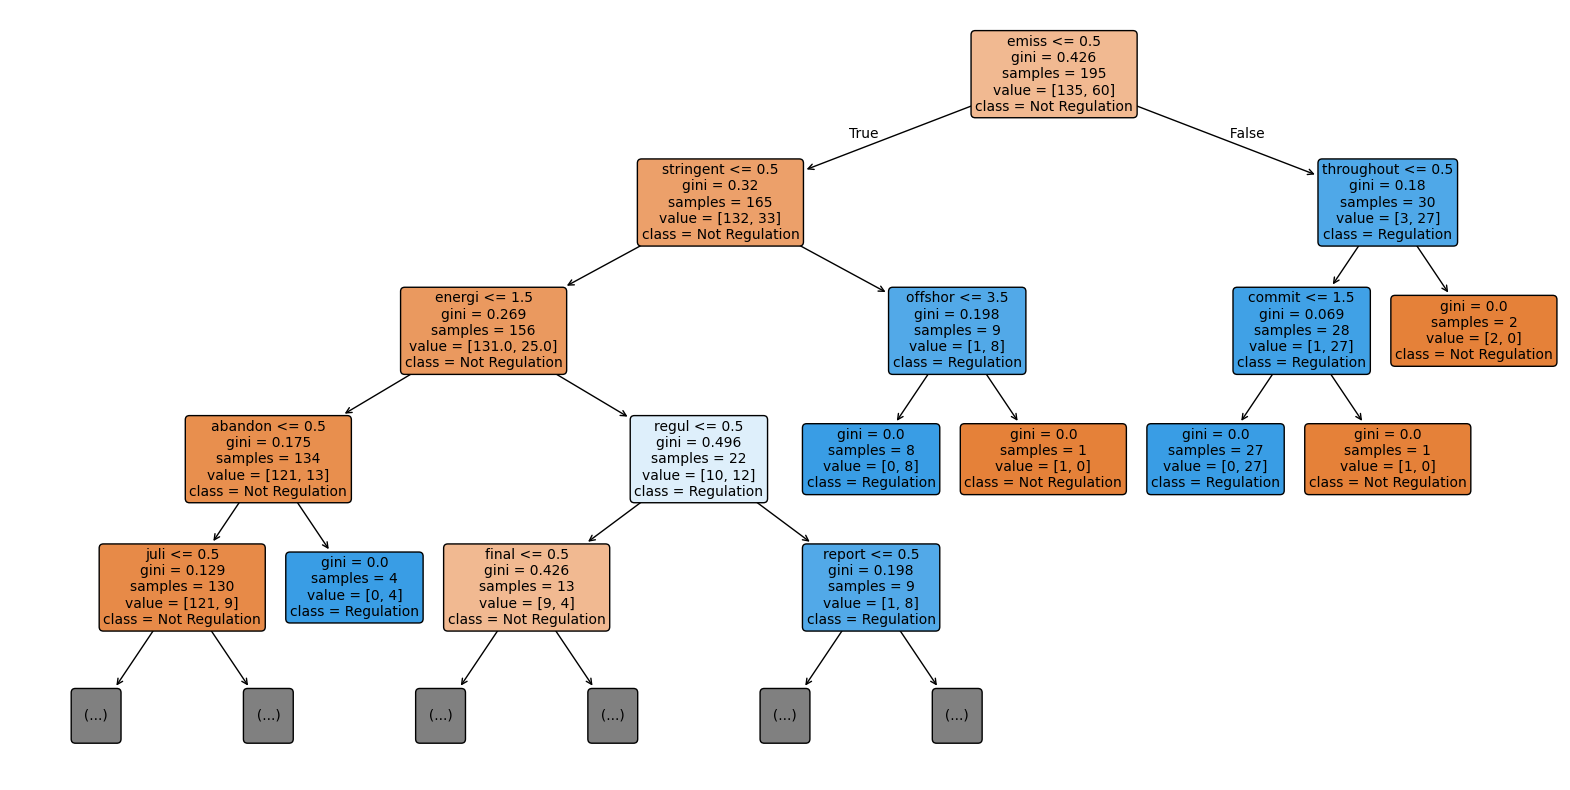

In [115]:
# ---- Visualize the Decision Tree ----
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualizing the tree with the DTM
plt.figure(figsize=(20, 10))  # Set the figure size for better readability
plot_tree(dt_model, 
          feature_names=vectorizer.get_feature_names_out(),  # Show the feature names (words)
          class_names=['Not Regulation', 'Regulation'],  # Simplify the class names if needed
          filled=True,  # Fill the nodes with colors
          rounded=True,  # Round the corners of the nodes
          fontsize=10, # Font size for readability
          max_depth=4)  # Limit the depth of the tree to the first 4 levels)  
plt.show()


### Random Forests



In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Assuming 'y_train' and 'X_train' are the training features and labels,
# and 'y_test' and 'X_test' are the testing features and labels.

# Convert the target variable to integer type (binary classification) for training and testing sets
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Train a Random Forest Classifier using the training data (X_train, y_train)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)  # Set random state for reproducibility
rf_model.fit(X_train, y_train)  # Fit the model using training data

# Predict on the testing data to check out-of-sample performance
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance on the testing data
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Testing Accuracy: {accuracy_rf:.4f}")

# Get the classification report for more detailed evaluation (precision, recall, F1 score)
class_report_rf = classification_report(y_test, y_pred_rf)
print("Testing Classification Report:")
print(class_report_rf)

# Confusion matrix for testing data to see how well the model performed
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix (Testing Data):")
print(conf_matrix_rf)


Testing Accuracy: 0.7692
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84        41
           1       0.85      0.46      0.59        24

    accuracy                           0.77        65
   macro avg       0.80      0.70      0.72        65
weighted avg       0.79      0.77      0.75        65


Confusion Matrix (Testing Data):
[[39  2]
 [13 11]]


In [117]:

# Assuming rf_model is the trained Random Forest model and vectorizer is your CountVectorizer
# Get the feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Get the words associated with the features (from the CountVectorizer)
words = np.array(vectorizer.get_feature_names_out())  # Get the feature names (words) from CountVectorizer

# Create a DataFrame to view the words and their associated importances
importances_df = pd.DataFrame({'word': words, 'importance': importances})

# Sort the words by importance (higher importance means more important)
importances_df_sorted = importances_df.sort_values(by='importance', ascending=False)

# Step 4: Display the top 20 words most important for predicting `regulation_present`
top_words = importances_df_sorted.head(20)

# Display the top words
print("\nTop 20 words most associated with regulation_present (Random Forest):")
print(top_words)



Top 20 words most associated with regulation_present (Random Forest):
             word  importance
364         emiss    0.033796
919         regul    0.022750
372        energi    0.022126
171        climat    0.018584
1041        state    0.018558
437         feder    0.014938
921    regulatori    0.014175
577         initi    0.013130
909         reduc    0.013077
382   environment    0.012961
873        propos    0.011603
544         impos    0.011505
487            ga    0.010972
156         chang    0.010080
815        permit    0.009626
495           ghg    0.009580
507     greenhous    0.009414
42            air    0.008882
475       fractur    0.008333
472        fossil    0.008164


I implemented four different types of classifiers using a bag-of-words approach: Naive Bayes, Logistic Regression, Decision Trees, and Random Forests. Among these, the best-performing models were Naive Bayes and Logistic Regression, which had similar performance in terms of testing accuracy and precision. Both models demonstrated strong predictive power for the given task, with Logistic Regression slightly outperforming Naive Bayes in accuracy and precision. Yet, Naive Bayes achieved the highest recall among all models, which is the metric I prioritize. High recall is essential in this context because my goal is to identify as many relevant instances (segments discussing environmental or energy topics) as possible, even at the cost of slightly lower precision. By maximizing recall, Naive Bayes ensures that fewer relevant instances are missed, which is critical for a comprehensive analysis of environmental and energy-related discussions. In my case, lower precision means that the model is more likely to predict a segment as being in the "environmental/energy" category (class 1) when it doesn’t actually belong to that category, but I am willing to accept a model with lower precision if it has higher recall. Decision Trees and Random Forests performed significantly worse in both testing accuracy and especially had poor recall. These models, despite their flexibility and ability to capture complex patterns, may have been hindered by overfitting or the lack of sufficient feature engineering in this bag-of-words setup. Random Forests, which aggregate multiple decision trees to reduce overfitting, had the best precision of all the models, yet the worst recall. 



## Part B: Feed Forward Neural Network 

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(42)

# Step 1: Preprocessing (apply your existing preprocessing function)
stop_words = set(stopwords.words('english'))
labeled_corpus = labeled['chunk_text'].tolist()

# Preprocess the text
labeled_preprocessed = [preprocess_text(doc, stop_words) for doc in labeled_corpus]

# Step 2: Limit the features to a smaller number (e.g., 2000 features)
# vectorizer make this an embedding 
vectorizer = CountVectorizer(min_df=5, max_features=2000)  # Limit to 2000 most frequent words
X = vectorizer.fit_transform(labeled_preprocessed)
y = labeled['regulation_present'].astype(int)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Step 4: Standardize the data (important for neural networks)
scaler = StandardScaler(with_mean=False)  # with_mean=False for sparse matrices
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Convert data into PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled.toarray(), dtype=torch.float32)  # Convert to dense array
X_test_tensor = torch.tensor(X_test_scaled.toarray(), dtype=torch.float32)  # Convert to dense array
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape to match output format
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)  # Reshape to match output format

# Step 6: Create DataLoader for training and testing sets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

# Step 7: Build a simpler neural network model in PyTorch
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)  # First hidden layer
        self.layer2 = nn.Linear(128, 64)  # Second hidden layer
        self.layer3 = nn.Linear(64, 1)  # Output layer
        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # ReLU activation for the first layer
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.layer2(x))  # ReLU activation for the second layer
        x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.layer3(x))  # Sigmoid activation for binary classification
        return x

# Step 8: Initialize the model
input_dim = X_train_tensor.shape[1]
model = FeedForwardNN(input_dim)

# Step 9: Set up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCELoss()  # Binary cross-entropy loss for binary classification

# Step 10: Train the model
epochs = 5
for epoch in tqdm(range(epochs)):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients before each step
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item() * inputs.size(0)  # Track the loss

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Step 11: Evaluate the model on the test set
model.eval()
correct = 0
total = 0
list_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()  # Convert probabilities to class labels (0 or 1)
        # print(predicted.numpy().shape)
        list_pred.extend(predicted.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


# 1. Accuracy
accuracy_nn = accuracy_score(y_test, list_pred)
print(f"Testing Accuracy: {accuracy_nn:.4f}")

# 2. Classification Report (precision, recall, F1-score)
class_report_nn = classification_report(y_test, list_pred)
print("Testing Classification Report:")
print(class_report_nn)

# 3. Confusion Matrix
conf_matrix_nn = confusion_matrix(y_test, list_pred)
print("\nConfusion Matrix (Testing Data):")
print(conf_matrix_nn)



100%|██████████| 5/5 [00:00<00:00, 16.97it/s]

Epoch 1/5, Loss: 0.6395
Epoch 2/5, Loss: 0.5132
Epoch 3/5, Loss: 0.3441
Epoch 4/5, Loss: 0.1914
Epoch 5/5, Loss: 0.1192
Test Accuracy: 0.7846
Testing Accuracy: 0.7846
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.84        41
           1       0.81      0.54      0.65        24

    accuracy                           0.78        65
   macro avg       0.79      0.73      0.75        65
weighted avg       0.79      0.78      0.77        65


Confusion Matrix (Testing Data):
[[38  3]
 [11 13]]


## Part C - Chat GPT 

I encountered some challenges with setting up the ChatGPT API for free use and also found Meta Llama 3 to be somewhat cumbersome for my workflow. Given time constraints, I opted for a more straightforward approach: I provided ChatGPT with my codebook and pasted each chunk of text into the chat interface. ChatGPT then returned a binary (0/1) classification for each chunk, which I manually copied into an Excel file. In the same Excel sheet, I added another column containing my own coding of the chunks for comparison. Although I initially coded 270 chunks, I limited this process to 150 chunks when using ChatGPT due to the time-intensive nature of the task. For ChatGPT, I provided explicit instructions to ensure consistent classifications aligned with my research objectives. My prompt to ChatGPT was as follows:

*This binary variable captures the presence of either environmental or energy regulation specifically within the text. For an entry to be coded as "1," there must be an explicit reference to regulatory terms that are clearly related to environmental or energy concerns. General mentions of "governmental regulation" or similar non-specific terms are not included here. Examples of indicators include references to specific agencies or terms like "EPA regulations" or "energy compliance."*

This instruction reflects the critical focus of my research on identifying explicit regulatory discussions directly tied to environmental or energy contexts. By providing clear guidelines, I aimed to maximize consistency and precision in the classification process, ensuring that only relevant segments were flagged as "1." This approach highlights the nuanced nature of the coding process and the importance of domain-specific instructions for effective text classification.



In [119]:
from sklearn import metrics
## Loading the dataset 
chat_data = pd.read_excel("/Users/teri/Documents/GitHub/Energy10k/sample_270_chatGPT.xlsx")

y_true = chat_data['regulation_present_me']
y_pred_gpt = chat_data['regulation_present_chatgpt']

# 1. Accuracy
accuracy_gpt = accuracy_score(y_true, y_pred_gpt)
print(f"Testing Accuracy: {accuracy_gpt:.4f}")

# 2. Classification Report (precision, recall, F1-score)
class_report_gpt = classification_report(y_true, y_pred_gpt)
print("Testing Classification Report:")
print(class_report_gpt)

# 3. Confusion Matrix
conf_matrix_gpt = confusion_matrix(y_true, y_pred_gpt)
print("\nConfusion Matrix (Testing Data):")
print(conf_matrix_gpt)



Testing Accuracy: 0.8919
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        49
           1       0.84      0.84      0.84        25

    accuracy                           0.89        74
   macro avg       0.88      0.88      0.88        74
weighted avg       0.89      0.89      0.89        74


Confusion Matrix (Testing Data):
[[45  4]
 [ 4 21]]


In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

def plot_performance_metrics(accuracy_list, precision_list, recall_list, model_names):
    """
    Plot accuracy, precision, and recall for different models.
    
    Parameters:
    accuracy_list (list): List of accuracy scores for different models.
    precision_list (list): List of precision scores for different models.
    recall_list (list): List of recall scores for different models.
    model_names (list): List of model names.
    
    Returns:
    None
    """
    # Creating a figure and axis for plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plotting Accuracy
    axes[0].bar(model_names, accuracy_list, color='skyblue')
    axes[0].set_title('Accuracy Comparison')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim([0, 1])
    
    # Plotting Precision
    axes[1].bar(model_names, precision_list, color='salmon')
    axes[1].set_title('Precision Comparison')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0, 1])
    
    # Plotting Recall
    axes[2].bar(model_names, recall_list, color='lightgreen')
    axes[2].set_title('Recall Comparison')
    axes[2].set_ylabel('Recall')
    axes[2].set_ylim([0, 1])

    # Displaying the plot
    plt.tight_layout()
    plt.show()

# Assuming you have these variables with the respective metrics
accuracy_list = [accuracy_nb, accuracy_logit, accuracy_dt, accuracy_rf, accuracy_nn, accuracy_gpt]
# Get classification report for Naive Bayes as a dictionary
class_report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
class_report_logit = classification_report(y_test, y_pred_logit, output_dict=True)
class_report_dt = classification_report(y_test, y_pred_dt, output_dict=True)
class_report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
class_report_nn = classification_report(y_test, list_pred, output_dict=True)
class_report_gpt = classification_report(y_true, y_pred_gpt, output_dict=True)

# Extract precision, recall, and F1 for class '1' (positive class)
precision_list = [
    class_report_nb['1']['precision'],
    class_report_logit['1']['precision'],
    class_report_dt['1']['precision'],
    class_report_rf['1']['precision'],
    class_report_nn['1']['precision'],
    class_report_gpt['1']['precision']
]

recall_list = [
    class_report_nb['1']['recall'],
    class_report_logit['1']['recall'],
    class_report_dt['1']['recall'],
    class_report_rf['1']['recall'],
    class_report_nn['1']['recall'],
    class_report_gpt['1']['recall']
]


# Define the model names in the desired order
model_names = ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Neural Network', 'GPT']


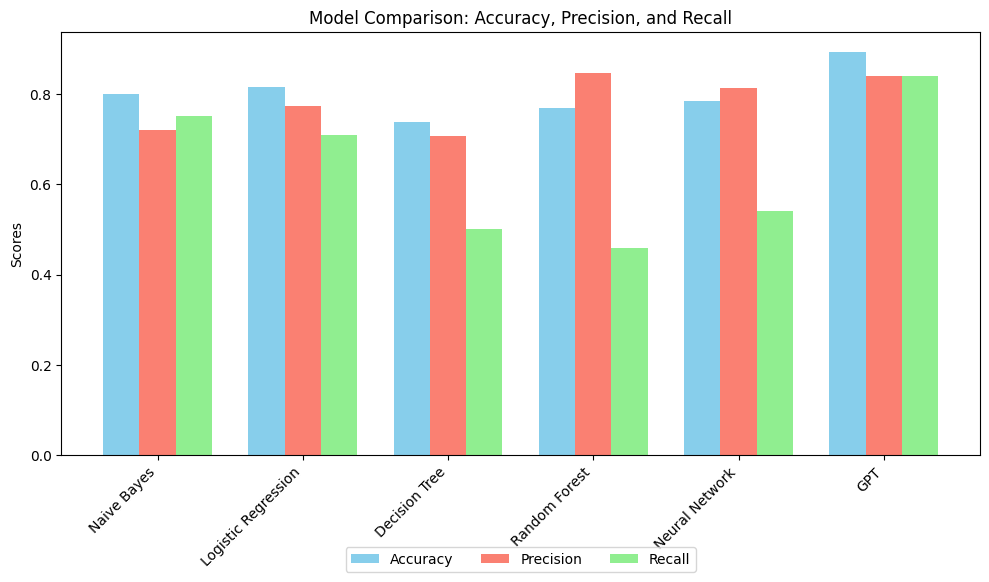

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Define the width of the bars and the number of models
bar_width = 0.25
index = np.arange(len(model_names))  # The positions of the bars on the x-axis

# Creating a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the metrics
bar1 = ax.bar(index, accuracy_list, bar_width, label='Accuracy', color='skyblue')
bar2 = ax.bar(index + bar_width, precision_list, bar_width, label='Precision', color='salmon')
bar3 = ax.bar(index + 2 * bar_width, recall_list, bar_width, label='Recall', color='lightgreen')

# Adding labels and title
ax.set_xlabel('')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: Accuracy, Precision, and Recall')

# Setting the x-ticks to be the model names and rotating them by 45 degrees
ax.set_xticks(index + bar_width)  # Place the ticks in the middle of the grouped bars
ax.set_xticklabels(model_names, rotation=45, ha='right')

# Move the legend to the bottom left corner below the x-axis label
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=3)

# Display the plot
plt.tight_layout()
plt.show()


the plot above illustrates the accuracy, precision, and recall for each model. For precision and recall, I focused specifically on the "1" category, which represents instances predicted to belong to the environmental/energy category. This focus was deliberate, as my primary interest lies in identifying segments that discuss environmental or energy-related topics, ensuring comprehensive coverage of these critical areas.

Among all the models, ChatGPT clearly stands out as the best-performing model overall, excelling across all metrics. Beyond ChatGPT, Naive Bayes emerges as the next most effective model, offering a balance of high recall and robust performance overall. While Logistic Regression demonstrates slightly higher accuracy and significantly higher precision than Naive Bayes, my analysis prioritizes recall. Recall is vital in this context as it ensures that all relevant segments discussing environmental or energy topics are identified, even if it comes at the cost of a few false positives. This approach aligns with the overarching goal of minimizing missed opportunities to capture meaningful discussions, which is paramount for my research objectives.

## Part D: Categorizing Unlabeled Data 

Since ChatGPT was my best-performing model overall, I used the second-best model, Naive Bayes, for this section to ensure a robust comparison and demonstrate the performance of traditional machine learning approaches. For this task, I used 270 annotated 10-sentence chunks as the training data. Once the model was trained, I applied it to a dataset of 5,227 unlabeled chunks to classify them based on the presence of environmental or energy regulation.

In [122]:

# Assuming 'labeled' and 'unlabeled' DataFrame contain 'chunk_text' columns
labeled_corpus = labeled['chunk_text'].tolist()
unlabeled_corpus = unlabeled['chunk_text'].tolist()

# Define stopwords (using NLTK stopwords)
stop_words = set(stopwords.words('english'))

# Apply preprocessing function to both the labeled and unlabeled corpora
labeled_preprocessed = [preprocess_text(doc, stop_words) for doc in labeled_corpus]
unlabeled_preprocessed = [preprocess_text(doc, stop_words) for doc in unlabeled_corpus]

# Define features and labels (only for labeled data)
vectorizer = CountVectorizer(min_df=5)  # min_df filters out words that appear in fewer than 5 documents
X_labeled = vectorizer.fit_transform(labeled_preprocessed)  # Fit on labeled data
X_unlabeled = vectorizer.transform(unlabeled_preprocessed)  # Transform the unlabeled data using the same vectorizer

y_labeled = labeled['regulation_present']  # Labels for the labeled dataset




In [123]:
# Train the Naive Bayes Model on the labeled data
nb_model = MultinomialNB()
nb_model.fit(X_labeled, y_labeled)  # Fit the Naive Bayes model using the labeled data

#  Predict on the unlabeled data
unlabeled_preds = nb_model.predict(X_unlabeled)

#  Save predictions for the unlabeled data
unlabeled_data_with_preds = unlabeled[['chunk_text']].copy()
unlabeled_data_with_preds['predicted_regulation_present'] = unlabeled_preds

# save 
#unlabeled_data_with_preds.to_csv('unlabeled_data_predictions.csv', index=False)




In [124]:
# Calculate the proportion of each category (0 or 1) in the predicted labels
category_proportions = unlabeled_data_with_preds['predicted_regulation_present'].value_counts(normalize=True)

# Display the proportions of each category
print("\nProportion of each category in the unlabeled data:")
print(category_proportions)


Proportion of each category in the unlabeled data:
predicted_regulation_present
0.0    0.592692
1.0    0.407308
Name: proportion, dtype: float64


In [125]:
# Display the proportions in the hand-coded data 
labeled['regulation_present'].value_counts(normalize=True)

regulation_present
0.0    0.676923
1.0    0.323077
Name: proportion, dtype: float64

Looking at the distribution of my data, I observed that approximately 40% of the chunks in my dataset mention environmental or energy regulation. This aligns reasonably well with my training data, where 32% of the chunks were coded as mentioning regulation. The similarity between these percentages suggests consistency in the data and coding process. This distribution is also logical given the context of the dataset, which comprises chunks extracted from the Risk Factors sections of 10-K reports filed by companies in the mining and utilities sectors. These industries are inherently sensitive to environmental and energy regulations, as compliance with such policies often represents both a critical operational challenge and a source of significant financial risk.

If the goal is to measure exposure to environmental regulation, these companies, which are likely to have high exposure, do indeed discuss environmental and energy regulation frequently in their filings. This provides a strong signal that my methodology is capturing relevant content. Companies in these sectors, by necessity, must highlight regulatory risks as a key concern in their disclosures, validating the utility of focusing on these chunks to gauge regulatory exposure.

However, the next step poses a methodological challenge. Currently, I have divided each document into chunks, and the coding process evaluates each chunk individually. Aggregating these chunk-level classifications up to the section level or even the document level requires careful consideration. For instance:

Should I calculate the proportion of chunks mentioning regulation and use that as the section-level score?
Or, should I simply flag sections as "exposed" if any chunk within them mentions regulation?
Both approaches have implications for how exposure is interpreted. A proportion-based aggregation provides a nuanced view of regulatory discussion density, while a binary flag ensures any mention is captured but could overestimate exposure. Deciding on the best aggregation method will depend on the specific research question and the granularity needed in the results.



